---

_You are currently looking at **version 1.2** of this notebook. To download notebooks and datafiles, as well as get help on Jupyter notebooks in the Coursera platform, visit the [Jupyter Notebook FAQ](https://www.coursera.org/learn/python-social-network-analysis/resources/yPcBs) course resource._

---

# Assignment 4

In [1]:
######################
#                     課題                    #
# Q1. Graphからアルゴリズムをリバースエンジニアリングする
# Q2. Graphの失われたノード[人]属性を予測する
# Q3. 新しい(E-Mailのやりとりの)繋がりの予測 (future_connectionはデバッグ用に提供される)
######################

#####!!REVIEW!!##
# ネットワークのモデリング
# ◆ Preferential Attachment Model◆
#      ネットワーク上のDegreeの内容から将来どう派生するかをModelingする
#   　　　特徴: degreeが多いノードほど数が少なく、ほどんどのノードはdegreeが1,2など = Power-low degree destribution
#      理由: 有名なactorは映画に引っ張りだこなので新しく入った他のactorと結びつく可能性が高いなどの理由。
#                Clustering Coefficientが小さい。(shortest pathも小さい)
#
#     P(k) ... degree distributionを求める式 k個のdegreeを持つノードの数 / 全ノード数
#     Pの最も大きくなる k とは ... histogram上で一番多いdegree
#
#         degrees = G.degree() # key: node名, value: degree
#         degree_values = sorted(set(degrees.values())) # degree情報だけをソート
#         # Histogramを求める(degreeの小さいものから分布をリストに格納する)
#         histogram = [ list(degrees.values()).count(i) / float(nx.number_of_nodes(G)) for i in degree_values ]
#
#         import matplotlib.pyplot as plt
#         plt.bar(degree_values, histogram)
#         plt.xlabel('Degree')
#         plt.ylabel('Fraction of Nodes') # どれぐらいあるか(分布しているか)
#         plt.show()
#         
#         - node数で割っているので、少数になる(現実世界ではデータ多いのでlogで表示する（下ほど稀）)
#          - In-Degreeで求めたい時は G.in_degree()を使用する。
#            ⅰ. ２つのノードと1つのedgeから始まる
#            ⅱ. ノードを１つのedgeと一緒に追加していく（ランダムにだが、probabilityはdegreeの数に比例する）　◆◆特徴◆◆
#    Preferential Attachment Modelの代表的なメソッド: barabashi_albert_graph(n,m)   n: 新しいノード、m: 既存のノード、 結びついたグラフを返す
#         G = nx.barabashi_albert_graph(1000000, 1) # 1000000の新しいノードを1つの既存のノードに結び付けさせる
#         degrees = G.degree()
#         degree_values = sorted(set(degrees.values())) # degree情報だけをソート
#         # Histogramを求める(degreeの小さいものから分布をリストに格納する)
#         histogram = [ list(degrees.values()).count(i) / float(nx.number_of_nodes(G)) for i in degree_values ]
#
#         plt.bar(degree_values, histogram, 'o')
#         plt.xlabel('Degree')
#         plt.ylabel('Fraction of Nodes')
#         plt.xscale('log')
#         plt.yscale('log')
#         plt.show()
#         
# ◆ Small World Model◆
#      Path Length and ClusteringをModelingする
#   　　　特徴: Real NetworkはClustering Coefficientが高い傾向があり、平均path-lengthが小さい。
#      何故か: 限られた少数のノードが多くのdegreeを持つので、そのノードがハブとなり(ハブが多いほど)、clustering coefficientが大きく、平均path-lengthが小さくなるから。
#                pが小さい時点ではClustering Coefficientが高くshortest pathは小さい。
#   　　　k: nearest neighborの数(edgeで繋がる)、p: ランダムなノードとrewireを行うprobability(通常かなり小さい)
#      pが小さくrewireがない状態だとLocal Clustering Coefficientは大きい。pが大きくなると今度は平均path-lengthが小さくなる。
#      pが0から1の間ではaverage shortest pathが急速に減り、average clustering coefficientがゆっくり減る。◆◆特徴◆◆
#
#         G = nx.barabashi_albert_graph(1000, 4) # 1000の新しいノードを4つの既存のノードに結び付けさせる
#         print(nx.average_clustering(G))
#         => 0.0202859
#         print(nx.average_shortest_path_length(G))
#         => 4.1694294
#         
#    Small World Modelの代表的なメソッド: watts_strogatz_graph(n,k,p)   n: ノード数
#         G = nx.watts_strogatz_graph(1000, 6, 0.04) #  p=0.04は大きすぎるような..
#         degrees = G.degree()
#         degree_values = sorted(set(degrees.values())) # degree情報だけをソート
#         # Histogramを求める(degreeの小さいものから分布をリストに格納する)
#         histogram = [ list(degrees.values()).count(i) / float(nx.number_of_nodes(G)) for i in degree_values ]
#         plt.bar(degree_values, histogram, 'o')
#         plt.xlabel('Degree')
#         plt.ylabel('Fraction of Nodes')   <====== ほとんどのノードがDegree=6になる。(理由:probabilityで一律に繋ぎ直しているから)
#         plt.show()
#
# ◆ Link Prediction◆
#      代表利用例：フレンド・レコメンド システム
#      (◆特徴◆ネットワーク上のどのノードがノードAと結びつきそうかを推測する)
#      ネットワーク上のに次どのようなedgeが構成されそうかをModelingする
#   　　　特徴: Real NetworkはClustering Coefficientが高い傾向があり、平均path-lengthが小さい。
#
#       Triadic closure: 人がソーシャルネットワークの中でコネクションを築く傾向
#       
#      5 basic measures
#        1. 共通の友人が多い
#         - Common Neighbors  ... comm_neigh(X,Y) = | N(X) かつ N(Y) | 、N(X) : XのNeighbors(edgeで繋がっている)
#        2. (共通の友人 / 友人の数) が多い
#         - Jaccard Coefficient  ... jacc_coedd(X,Y) = comm_neigh(X,Y)  ÷  | N(X) 又は N(Y) |  (重複カウントはしない。)
#        3. 共通の友人の友人数が少ない友人が沢山いる
#         - Resource Allocation Index  ... 共通のNeighborが多く、そのNeighborのdegreeが小さいほど値が大きくなるIndex
#               共通のNeighborがZとしてそのZのdegreeが４の場合、1/4となる。これを全ての共通Neighborに対し求めsumする。
#         - Adamic-Adar Index ... Resource Allocation Index のpenalize方法をlog()に変えただけ(degreeが3ならlog(3)で割る)
#        4. 友人がどっちもとても多い(ひょっとして友人では?)
#         - Preferential Attachment Score ... pref_attach(X,Y) = | N(X)| * | N(Y) |  、各々のdegreeを沢山持っていたらより繋がりやすい。
#       
#　　　　　　　　　# 全ノードのcommon neighbor(お互いedgeで繋がりのあるノードの数)を求める式
#         common_neigh = [ (e[0], e[1], len(list(nx.common_neighbors(G, e[0], e[1])))) for e in nx.non_edges(G) ]
#         sorted(common_neigh, key=operator.itemgetter(2), reverse=True)
#         print(common_neigh) 
#       
#　　　　　　　　　# 全ノードのcommon neighborを全てのneighborsで割ってノーマライズしたものを求める式
#         L = list(nx.jaccard_coefficient(G))
#         L.sort(key=operator.itemgetter(2), reverse=True)
#         print(L)
#       
#　　　　　　　　　# 全ノードのcommon neighborを共通のneighborsのdegree数でピーナライズした(割る)もののsum()を求める式
#         L = list(nx.resource_allocation_index(G))
#         L.sort(key=operator.itemgetter(2), reverse=True)
#         print(L)
#       
#　　　　　　　　　# 全ノードのdegreeを元に計算する。値は整数(pref_attach(A,B)の値を求めるならAのdegree × Bのdegreeなので)
#         L = list(nx.preferential_attachment(G))
#         L.sort(key=operator.itemgetter(2), reverse=True)
#         print(L)
#
#    Community
#         2つのノード間のSoundarajan-Hopcroft score
#          = | N(X) かつ N(Y) | + 共通の友人の数だけsum(f(u))
#          ここで f(u) = { 1, u in same comm. as X and Y     0, otherwise}
#         同じコミュニティの場合、ボーナスする
#         | N(X) かつ N(Y) |  が全員同じコミュニティなら | N(X) かつ N(Y) | をもう一回足す。
#       ２つのメジャーな式
#         - Common Neighbors Soundarajan-Hopcroft score
#         - Resource Allocation Soundarajan-Hopcroft score
###############

import networkx as nx
import pandas as pd
import numpy as np
import pickle

---

## Part 1 - Random Graph Identification

For the first part of this assignment you will analyze randomly generated graphs and determine which algorithm created them.

In [2]:
P1_Graphs = pickle.load(open('A4_graphs','rb'))
P1_Graphs

<br>
`P1_Graphs` is a list containing 5 networkx graphs. Each of these graphs were generated by one of three possible algorithms:
* Preferential Attachment (`'PA'`)
* Small World with low probability of rewiring (`'SW_L'`)
* Small World with high probability of rewiring (`'SW_H'`)

Anaylze each of the 5 graphs and determine which of the three algorithms generated the graph.

*The `graph_identification` function should return a list of length 5 where each element in the list is either `'PA'`, `'SW_L'`, or `'SW_H'`.*

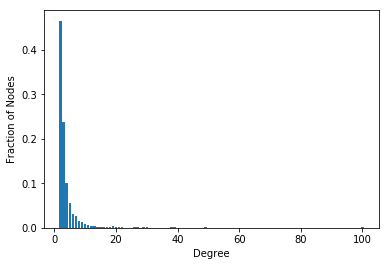

Clustering Coefficient:  0.03167539146454044
Ave. Shortest Path:  4.099161161161161


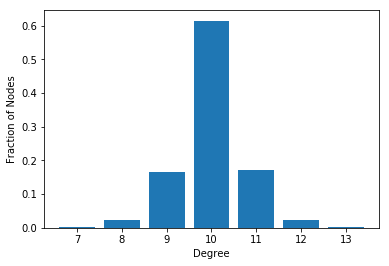

Clustering Coefficient:  0.5642419635919628
Ave. Shortest Path:  5.089871871871872


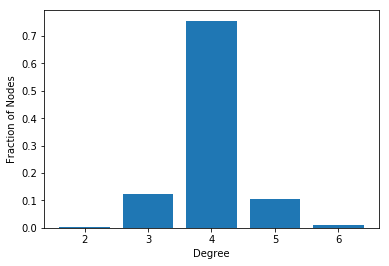

Clustering Coefficient:  0.4018222222222227
Ave. Shortest Path:  9.378702269692925


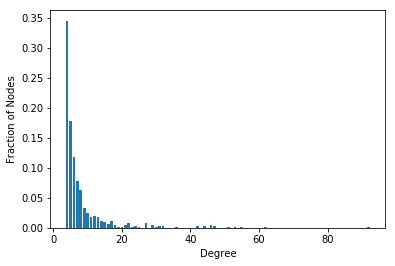

Clustering Coefficient:  0.03780379975223251
Ave. Shortest Path:  3.1048046283934134


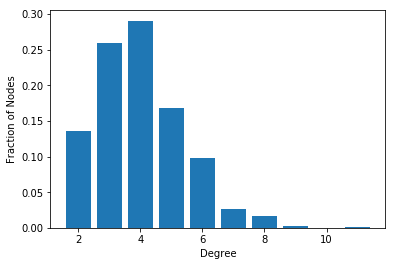

Clustering Coefficient:  0.0033037037037037037
Ave. Shortest Path:  5.0785509568313305


['PA', 'SW_L', 'SW_L', 'PA', 'SW_H']

In [7]:
def graph_identification():
    
    # Your Code Here
    # Preferential Attachment : histogramを見ればわかる
    # Small World with low probability of rewiring : Local Clustering Coefficientが大きい。
    # Small World with high probability of rewiring : 平均path-lengthが短くなるがLocal Clustering Coefficientも小さくなる
    
    for G in P1_Graphs:
        degrees = G.degree()
        degree_values = sorted(set(degrees.values())) # degree情報だけをソート
        
        histogram = [ list(degrees.values()).count(i) / float(nx.number_of_nodes(G)) for i in degree_values ]

        import matplotlib.pyplot as plt
        plt.bar(degree_values, histogram)
        plt.xlabel('Degree')
        plt.ylabel('Fraction of Nodes') # どれぐらいあるか
        plt.show()
    
        print('Clustering Coefficient: ', nx.average_clustering(G))
        print('Ave. Shortest Path: ', nx.average_shortest_path_length(G))
    
    return ['PA', 'SW_L', 'SW_L', 'PA', 'SW_H']# Your Answer Here
graph_identification()

---

## Part 2 - Company Emails

For the second part of this assignment you will be workking with a company's email network where each node corresponds to a person at the company, and each edge indicates that at least one email has been sent between two people.

The network also contains the node attributes `Department` and `ManagementSalary`.

`Department` indicates the department in the company which the person belongs to, and `ManagementSalary` indicates whether that person is receiving a management position salary.

In [2]:
G = nx.read_gpickle('email_prediction.txt')

print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 1005
Number of edges: 16706
Average degree:  33.2458


### Part 2A - Salary Prediction

Using network `G`, identify the people in the network with missing values for the node attribute `ManagementSalary` and predict whether or not these individuals are receiving a management position salary.

To accomplish this, you will need to create a matrix of node features using networkx, train a sklearn classifier on nodes that have `ManagementSalary` data, and predict a probability of the node receiving a management salary for nodes where `ManagementSalary` is missing.



Your predictions will need to be given as the probability that the corresponding employee is receiving a management position salary.

The evaluation metric for this assignment is the Area Under the ROC Curve (AUC).

Your grade will be based on the AUC score computed for your classifier. A model which with an AUC of 0.88 or higher will receive full points, and with an AUC of 0.82 or higher will pass (get 80% of the full points).

Using your trained classifier, return a series of length 252 with the data being the probability of receiving management salary, and the index being the node id.

    Example:
    
        1       1.0
        2       0.0
        5       0.8
        8       1.0
            ...
        996     0.7
        1000    0.5
        1001    0.0
        Length: 252, dtype: float64

In [44]:
def salary_predictions():
    
    # Your Code Here
    # create a feature matrix of nodes from a networkx graph
    df = pd.DataFrame(index=G.nodes())
    
    print('(Node)属性をピックアップ: ', G.nodes(data=True)[0], '(Edge)属性をピックアップ: ', G.edges(data=True)[0])
    df['dep'] = pd.Series(nx.get_node_attributes(G, 'Department'))
    df['manager'] = pd.Series(nx.get_node_attributes(G, 'ManagementSalary'))
    
    # nodeのdegreeなどの情報を取得
    print('\r\nノード0: ', nx.info(G, 0))
    print('\r\nノード1: ', nx.info(G, 1))
    df['degree'] = pd.Series(G.degree())
    df['clustering'] = pd.Series(nx.clustering(G)) # clustering coefficient for nodes

    # train, eval, testデータに分割
    df_train = df.dropna()
    df_test = df[df['manager'].isnull()]
    
    print('\r\n', df_train.head())
    print('\r\n Train Data Shape: ', df_train.shape, '\r\n Train Data Shape: ', df_test.shape)
    
    ### DecisionTreeここから　### 
    ### (SVCと違い、FN が FPより多い傾向がある: SVCやRLより本当は1なのに0と予想(見落とし)しやすい) ###
    ### よく使われるIrisデータセットとは..花のデータセット（萼の長さなど）
    # 利点1. 図示が簡単で人が理解しやすい。
    # 利点2. Normalizationが入らない。異なるfeature typeの混合にも良く合う。
    # Con. Overfitしやすい。generalization performanceのために大抵はensembleが必要(=>Randam Forest)
        
    from sklearn.tree import DecisionTreeClassifier
    from sklearn import tree
    classifier_name = 'Decision Tree'
    model = DecisionTreeClassifier(random_state=0) 
    model.fit(df_train[['dep', 'degree', 'clustering']], df_train['manager'])
    
    predicted = model.predict(df_test[['dep', 'degree', 'clustering']]) # AUC = 0.858 (AUC:0.88越えで満点)

    # Evaluate評価用(回答には関係ない)
    clf_eval = DecisionTreeClassifier(random_state=0)
    
    ### DecisionTreeここまで　###

    ### SVC(やLinear SVM)ここから　###
    ### input(X)にLinear式(sign(wx+b))等)やexp式を掛けてClass value(+1, -1(:Decision Boundary))を求める方法
    ### C parameter: The strength of regularization(小さいほどregularizeする)　デフォルト:1.0
    ### gamma(γ): kernel width parameter γが大きい場合、離れているほど似ていると判断する（よりシャープになる）
    ### gamma(γ)が大きいとCはあまり働かなくなる（gamma(γ)はexp式で使う。Linearでは使わない）
    ### LinearSVCは高次の疎なデータに良く合う。低次なデータに対しては他のアルゴリズムに劣る。
    ### LinearSVMはClassificationで表現できないこともある
    ### Kernelized SVCは高次低次どちらでも大丈夫。ダイレクトに確立を求めないので人が認識しづらい
    ### Kernelized SVCは効率がいい。(メモリ、スピード)
#     from sklearn.svm import SVC
#     from sklearn.model_selection import train_test_split
    
#     classifier_name = 'SVC'
#     model = SVC(kernel='linear', C=1.0)   #kernelのdefault=’rbf’
#     # Cross-varidation
#     from sklearn.model_selection import cross_val_score
#     print('Cross-validation (accuracy)',
#           cross_val_score(model,
#                           df_train[['dep', 'degree', 'clustering']], df_train['manager'], cv=5))
#     print('Cross-validation (AUC)',
#           cross_val_score(model,
#                           df_train[['dep', 'degree', 'clustering']], df_train['manager'], cv=5, scoring='roc_auc'))
#     print('Cross-validation (recall)',
#           cross_val_score(model,
#                           df_train[['dep', 'degree', 'clustering']], df_train['manager'], cv=5, scoring='recall'))
    
#      model.fit(df_train[['dep', 'degree', 'clustering']], df_train['manager'])
    
#     predicted = model.predict(df_test[['dep', 'degree', 'clustering']]) # AUC = 0.579　（やはり人の目で見てわかるレベルはSVCは向かない。）

#     #Evaluate評価用(回答には関係ない)
#     clf_eval = SVC(kernel='linear', C=1.0) 

    ### SVCここまで　###

    ### K-NN(Nearest Neighbors)ここから　### 
    # k=1だとover-fittingする
    # classifier, regressionどちらでも使える(ただr2 scoreはそれほど良くない)
#     from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
#     model = KNeighborsClassifier(n_neighbors=5).fit(df_train[['dep', 'degree', 'clustering']], df_train['manager'])
#     y_predicted = model.predict(X_test)

#     #Evaluate評価用(回答には関係ない)
#     clf_eval = KNeighborsClassifier(n_neighbors=5)

    ### K-NNここまで　### 
    
    
#     # Cross-varidation(Multiple-Foldsで確認する(平均値を求め特異値を除外するのに使う))
#     from sklearn.model_selection import cross_val_score
#     print('Cross-validation (accuracy)',
#           cross_val_score(model,
#                           df_train[['dep', 'degree', 'clustering']], df_train['manager'], cv=5))
#     print('Cross-validation (AUC)',
#           cross_val_score(model,
#                           df_train[['dep', 'degree', 'clustering']], df_train['manager'], cv=5, scoring='roc_auc'))
#     print('Cross-validation (recall)',
#           cross_val_score(model,
#                           df_train[['dep', 'degree', 'clustering']], df_train['manager'], cv=5, scoring='recall'))

#     # GridSearchCVを使うと多種のHyperParameterを一度に確認することもできる（Learning Curveを吟味する）
# 　　　　from sklearn.model_selection import GridSearchCV
#     grid_values = {'class_weight': ['balanced', {1:2}, {1:3}, {1:4}, {1:5}, {1:10}, {1:20}, {1:50} ]}
#     for i, eval_metric in enumerate(('precision', 'recall', 'f1', 'roc_auc')):
#         grid_custom = GridSearchCV(model, param_grid=grid_values, scoring=eval_metric)
#         grid_custom.fit(df_train[['dep', 'degree', 'clustering']], df_train['manager'])
#         print('Grid best parameter (max. {0}) :  {1}'.format(eval_metric, grid_custom.best_params_))
#         print('Grid best score ({0}) :  {1}'.format(eval_metric, grid_custom.best_score_))


    # Evaluateする場合のみ以下を行う
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(df_train[['dep', 'degree', 'clustering']], df_train['manager'], random_state=9)
    clf_eval.fit(X_train, y_train)
    y_predicted = clf_eval.predict(X_test)
    print ('\n予測データ: ', y_predicted[0:5])
    print ('実際のデータ: \r\n', y_test[0:5])
    print('\n Accuracy on Training Dataset: {:.2f}'.format(clf_eval.score(X_train, y_train)))    
    print('\n Accuracy on Test Dataset: {:.2f}'.format(clf_eval.score(X_test, y_test)))

    import matplotlib.pyplot as plt


    # Confusion Matrix(TP,FP,FN,TN)を求める
    from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, auc
    confusion = confusion_matrix(y_test, y_predicted)
    print('\nMost frequent class({} classifier)\n[[TN, FP]\n[FN,TP]]=>\n'.format(classifier_name), confusion)
    print('\nrecall:  TP / (TP + FN)　 FNが少ないと高い:必ず1をひろいあげるが、間違いで1と判定することも多い(厳格なものに向く) ')
    print('precision: TP / (TP + FP) FPが少ないと高い:正確さを追求し見落としが多い(分類するものに向く)')
    from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
    print('\nAccuracy=> {:.2f}'.format(accuracy_score(y_test, y_predicted)))
    print('Precision=> {:.2f}'.format(precision_score(y_test, y_predicted)))
    print('Recall=> {:.2f}'.format(recall_score(y_test, y_predicted)))
    print('F1=> {:.2f}'.format(f1_score(y_test, y_predicted)))
    from sklearn.metrics import classification_report # Multi Class Predictionにも使える
    print(classifier_name + ' Report=>\n', classification_report(y_test, y_predicted, target_names=['not 1', '1']))

#     # Precision Recall Curveを表示する(右上(一番良い箇所)にグラフがよる点がと良い点となる)
#     precision, recall, threshold = precision_recall_curve(y_test, y_predicted)
#     closest_zero = np.argmin(np.abs(threshold))
#     closest_zero_p = precision[closest_zero]
#     closest_zero_r = recall[closest_zero]
#     plt.figure()
#     plt.xlim([0.0, 1.01])
#     plt.ylim([0.0, 1.01])
#     plt.plot(precision, recall, lw=3)
#     plt.xlabel('Precision', fontsize=16)
#     plt.ylabel('Recall', fontsize=16)
#     plt.title ("Precision-recall curve", fontsize=16)
#     plt.axes().set_aspect('equal')
#     plt.show()

#     # ROC Curve(左上に近くカーブするグラフ(カーブの右下が広い)が良い)
#     fpr, tpr, _ = roc_curve(y_test, y_predicted)
#     roc_auc = auc(fpr, tpr)
#     plt.figure()
#     plt.xlim([0.0, 1.01])
#     plt.ylim([0.0, 1.01])
#     plt.plot(fpr, tpr, lw=3, label=' ROC curve (area = {:0.2f})'.format(roc_auc)) # 
#     plt.xlabel('False Positive Rate', fontsize=16)
#     plt.ylabel('True  Positive Rate', fontsize=16)
#     plt.title('ROC Curve', fontsize=16)
#     plt.legend(loc='lower right', fontsize=11)
#     plt.axes().set_aspect('equal')
#     plt.show()
    
    return pd.Series(predicted, index=df_test.index)# Your Answer Here　（4点満点で3.5pt獲得）
ans = salary_predictions()
# print('Answer[:4]\n', ans[:4])

(Node)属性をピックアップ:  (0, {'Department': 1, 'ManagementSalary': 0.0}) (Edge)属性をピックアップ:  (0, 1, {})

ノード0:  Node 0 has the following properties:
Degree: 44
Neighbors: 1 17 316 146 581 268 221 218 18 734 178 380 0 459 215 250 148 73 74 248 498 226 101 377 177 103 560 309 88 5 297 313 223 238 368 266 222 283 6 64 65 166 120

ノード1:  Node 1 has the following properties:
Degree: 52
Neighbors: 0 74 17 316 1 268 495 377 549 310 218 215 147 106 21 225 82 254 155 146 85 284 189 250 726 548 224 568 221 52 255 187 127 199 121 84 537 351 222 128 616 280 450 232 459 641 979 368 317 142 560

    dep  manager  degree  clustering
0    1      0.0      44    0.276423
3   21      1.0      71    0.384910
4   21      1.0      96    0.318691
6   25      1.0     115    0.155183
7   14      0.0      72    0.287785

 Train Data Shape:  (753, 4) 
 Train Data Shape:  (252, 4)

予測データ:  [ 0.  0.  0.  0.  0.]
実際のデータ: 
 813    0.0
859    1.0
365    0.0
52     0.0
584    0.0
Name: manager, dtype: float64

 Accuracy on Tra

### Part 2B - New Connections Prediction

For the last part of this assignment, you will predict future connections between employees of the network. The future connections information has been loaded into the variable `future_connections`. The index is a tuple indicating a pair of nodes that currently do not have a connection, and the `Future Connection` column indicates if an edge between those two nodes will exist in the future, where a value of 1.0 indicates a future connection.

In [10]:
future_connections = pd.read_csv('Future_Connections.csv', index_col=0, converters={0: eval})
future_connections.head(10) # 1: 未来でコネクションができる、2 : 未来でもコネクションができていない

,Future Connection
"(6, 840)",0.0
"(4, 197)",0.0
"(620, 979)",0.0
"(519, 872)",0.0
"(382, 423)",0.0
"(97, 226)",1.0
"(349, 905)",0.0
"(429, 860)",0.0
"(309, 989)",0.0
"(468, 880)",0.0


Using network `G` and `future_connections`, identify the edges in `future_connections` with missing values and predict whether or not these edges will have a future connection.

To accomplish this, you will need to create a matrix of features for the edges found in `future_connections` using networkx, train a sklearn classifier on those edges in `future_connections` that have `Future Connection` data, and predict a probability of the edge being a future connection for those edges in `future_connections` where `Future Connection` is missing.



Your predictions will need to be given as the probability of the corresponding edge being a future connection.

The evaluation metric for this assignment is the Area Under the ROC Curve (AUC).

Your grade will be based on the AUC score computed for your classifier. A model which with an AUC of 0.88 or higher will receive full points, and with an AUC of 0.82 or higher will pass (get 80% of the full points).

Using your trained classifier, return a series of length 122112 with the data being the probability of the edge being a future connection, and the index being the edge as represented by a tuple of nodes.

    Example:
    
        (107, 348)    0.35
        (542, 751)    0.40
        (20, 426)     0.55
        (50, 989)     0.35
                  ...
        (939, 940)    0.15
        (555, 905)    0.35
        (75, 101)     0.65
        Length: 122112, dtype: float64

Name: 
Type: Graph
Number of nodes: 1005
Number of edges: 16706
Average degree:  33.2458


df_train.head() => 
             Future Connection  Common Neighbors  Preferential Attachment Score
(6, 840)                  0.0                 9                           2070
(4, 197)                  0.0                 2                           3552
(620, 979)                0.0                 0                             28
(519, 872)                0.0                 2                            299
(382, 423)                0.0                 0                            205


len(df):  488446 
len(df[df['Future Connection'] == 1.0]):  29332 
len(df_train):  366334 
len(df_test):  122112
predict_proba[:2] =>  [[ 1.          0.        ]
 [ 0.98706633  0.01293367]] 
len(predict_proba) =>  122112 
len(df_test) =>  122112 
predict_proba_positive[:2] =>  [0.0, 0.012933672883679113]


test:predict_proba[:4] =>  [[ 0.98696122  0.01303878]
 [ 0.          1.        ]
 [ 1.          0.      

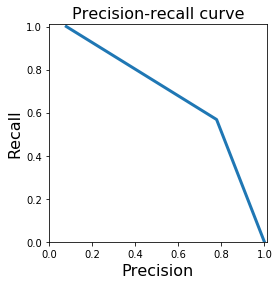

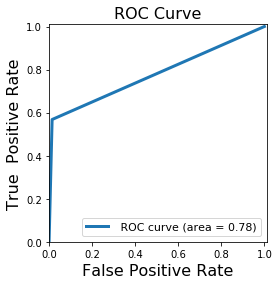

Answer[:4]
 (107, 348)    0.000000
(542, 751)    0.012934
(20, 426)     0.000000
(50, 989)     0.014211
dtype: float64


In [46]:
def new_connections_predictions():
    
    # Your Code Here
    import operator
    print(nx.info(G))

    
    # create a feature matrix of edges from a networkx graph
    df_def = future_connections.copy()
        
    ## 2つのDataFrameを結合する(GにはFeature_connectionが無く、future_connectionsにはnetworkxの情報がない)    
    # Inputデータ(1). "common_neighbors: 共通の知り合いの多さ"をGraphから情報取得
    df_def['Common Neighbors'] = df_def.index.map(lambda tpl: len(list(nx.common_neighbors(G, tpl[0], tpl[1]))))
    
    # Inputデータ(2). "preferential_attachment: 知り合いが多い人同士"をGraphから情報取得
    df_pa = pd.DataFrame(list(nx.preferential_attachment(G)), columns=['N1', 'N2', 'Preferential Attachment Score'])
    df_pa.index =[x for x in zip(df_pa.pop('N1'), df_pa.pop('N2'))]
    df = pd.merge(df_def, df_pa, left_index=True, right_index=True)
    
    # train, eval, testデータに分割
    df_train = df.dropna()
    df_test = df[df['Future Connection'].isnull()]
    
    # Training/Testデータ数をプリントアウト
    print('\n\ndf_train.head() => \n', df_train.head())
    print('\n\nlen(df): ', len(df), '\nlen(df[df[\'Future Connection\'] == 1.0]): ', len(df[df['Future Connection'] == 1.0]), '\nlen(df_train): ', len(df_train), '\nlen(df_test): ', len(df_test))
    
    ### DecisionTreeにはpredict_probaで確率は求められない。そもそもどうやってという話ではある　=> Random Forestを使う ###
    ### DecisionTreeここまで　###

    ### Naive Bases　classifiers (featureを独立して考えるので処理が早い(Costが低い)、が他のアルゴリズムに劣ることがままある)###
    # Naive Baseの"GaussianNB"であればそれぞれのfeatureはGaussian Distributionに従うとアルゴリズムは考える。
    # 非常に高次のデータに使われる .. テキストClassification （"Bernoulli"や"Multinomial"flavorsが特にテキストClassificationに使われる）
    # コンピューティングコストが低いので効率的にパラメータを吟味できる。（ここでは高次のデータではないので適さない）
    ### Naive Bases　classifiersここまで　###
    
    
    ### 　Random Forest ###
    ### ensembleの手法の一つ（ (異なる複数のModelを組み合わせ新たなModelを作る。各Modelのoverfitを防ぐ)）
    # 複数のdecision treeを使う（異なるデータセットで異なる変数(max_featuresなど)を組み合わせて）。出来上がるのはDecisionTree。
    # 利点１. NeuralNetwork（やSVM）と同等の精度を出すことができる（かなり良いパフォーマンス）
    # 利点2. 複雑なパラメータチューニングを必要としない。
    # 利点3. decision treeと同じでfeature typesが混合されていても大丈夫
    # Con. Decision Treeと違い、人間が理解しにくい。
    #          DecisionTreeと同じで高次のデータセットに向かない(テキストclassificationなどはlinearモデルが向く)
    #  - n_estimators: number of trees to use in ensamble(default:10)
    #     大きいほどoverfittingを防ぐ。 
    #  - max_features: デフォルトでうまく働く。ここは調整に避ける時間次第。
    #  - max_depth: デフォルトはNone(minimumなclassificationまでsplitする)
    #  - random_state: 再生産が可能なようにセットする
    #
    # Classification: RandomForestClassifier
    #  ・組み合わせは①各treeがそれぞれのクラスのprobabilityを出す。
    #  ②各treeでprobabilityを平均化する。③最も高いclassのprobabilityで予測する
    #
    # Regression: RandomForestRegressor
    #  ・組み合わせは各treeの予測値の平均を使う
    from sklearn.ensemble import RandomForestClassifier

    classifier_name = 'Random Forest'
    clf = RandomForestClassifier(n_estimators=10, random_state=0)
    clf.fit(df_train[['Common Neighbors', 'Preferential Attachment Score']], df_train['Future Connection'])    
    y_predicted = clf.predict(df_test[['Common Neighbors', 'Preferential Attachment Score']])
    
    proba = clf.predict_proba(df_test[['Common Neighbors', 'Preferential Attachment Score']])
    proba_positive = [ operator.itemgetter(1)(record) for record in proba ]
    print('predict_proba[:2] => ', proba[:2], '\nlen(predict_proba) => ', len(proba), '\nlen(df_test) => ', len(df_test), '\npredict_proba_positive[:2] => ', proba_positive[:2])
    answer = pd.Series(proba_positive, index=df_test.index) # AUC = 0.839 (AUC:0.88越えで満点)
    
    # Evaluate評価用(回答には関係ない)
    clf_eval = RandomForestClassifier(n_estimators=10, random_state=0)

    ### Random Forest ここまで　###

    
    ### 　Gradient Boosted Decision Tree(GBDT) ###
    ### ensembleの手法の一つ（ 一連のtreeをtrainし、次のtreeを試す前に微調整していく）
    # ProsとConはRandamForestとほぼ同じだが以下が違う。
    #   ・learning rateは細かなチューニングが必要
    #   ・コンピューティングコストが重い(高次なデータが向かない)。ただしAccuracyはずば抜けて良い。
    #  max_depthを小さくして使う(weak learner)
#     from sklearn.ensemble import GradientBoostingClassifier

#     classifier_name = 'GBDT'
#     clf = GradientBoostingClassifier().fit(df_train[['Common Neighbors', 'Preferential Attachment Score']], df_train['Future Connection'])    
#     # Evaluate評価用(回答には関係ない)
#     clf_eval = GradientBoostingClassifier()
    
    ### Gradient Boosted Decision Treeここまで　###

    
    ### 　Neural Network(Multi Layer Perceptron) ###
    ### featuresのtypeが似ている時はとても良い選択(例えばピクセル)
    ### featuresのtypeがかなり異なるものの場合はあまり良い選択ではない(=>DecitionTreeを使う)
    ### DeepLearningほど膨大なデータがいるのでデータが少ない時は向かない
    ### 人間が理解しにくくなる、GPU利用が必要になってくる(コストが高い)などのConがある。
    #  solver: weightsをlearningするアルゴリズム
    # regressionの場合、MLPRegressorを使う(activationはreluかtanh)
#     from sklearn.neural_network import MLPClassifier 
#     from sklearn.preprocessing import MinMaxScaler

#     classifier_name = 'NN(MLP)'
#     scaler = MinMaxScaler()
#     X_train_scaled = scaler.fit_transform(df_train[['Common Neighbors', 'Preferential Attachment Score']])
#     X_test_scaled = scaler.transform(X_test)
#     for units, alpha in zip([1, 10, 100], [0.01, 0.1, 1.0, 5.0]): # １レイヤーのユニット数: 10で十分だが(下は1レイヤーのみのMLP)
#         clf = MLPClassifier(hidden_layer_sizes = [units], solver='lbfgs', # solverはlocal optimaに影響する(default:adam)
#         alpha=alpha, # <= L2-regularization(小さいとoverfitしやすく、大きいとスムーズな線になる)
#         random_state=0).fit(X_train_scaled, df_train['Future Connection'])
#     # Evaluate評価用(回答には関係ない)
#     clf_eval = MLPClassifier(hidden_layer_sizes = [units], solver='lbfgs', alpha=alpha, random_state=0)

    ### Neural Network(Multi Layer Perceptron) ここまで　###

    
    # Evaluateする場合のみ以下を行う
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(df_train[['Common Neighbors', 'Preferential Attachment Score']], df_train['Future Connection'], random_state=9)
    clf_eval.fit(X_train, y_train)
    y_predicted = clf_eval.predict(X_test)
    proba_test = clf.predict_proba(X_test)
    proba_testpositive = [ operator.itemgetter(1)(record) for record in proba_test ]
    print('\n\ntest:predict_proba[:4] => ', proba_test[:4], '\ntest:predict_proba_positive[:4] => ', proba_testpositive[:4])
    
    print ('\n予測データ: ', y_predicted[0:5])
    print ('実際のデータ: \r\n', y_test[0:5])
    print('\n Accuracy of RF classifier on Training Dataset: {:.2f}'.format(clf_eval.score(X_train, y_train)))    
    print('\n Accuracy of RF classifier on test set: {:.2f}'.format(clf_eval.score(X_test, y_test)))

    
#     # Cross-varidation(Multiple-Foldsで確認する(平均値を求め特異値を除外するのに使う))
#     from sklearn.model_selection import cross_val_score
#     print('Cross-validation (accuracy)',
#           cross_val_score(clf,
#                           df_train[['dep', 'degree', 'clustering']], df_train['manager'], cv=5))
#     print('Cross-validation (AUC)',
#           cross_val_score(clf,
#                           df_train[['dep', 'degree', 'clustering']], df_train['manager'], cv=5, scoring='roc_auc'))
#     print('Cross-validation (recall)',
#           cross_val_score(clf,
#                           df_train[['dep', 'degree', 'clustering']], df_train['manager'], cv=5, scoring='recall'))

#     # GridSearchCVを使うと多種のHyperParameterを一度に確認することもできる（Learning Curveを吟味する）
# 　　　　from sklearn.model_selection import GridSearchCV
#     grid_values = {'class_weight': ['balanced', {1:2}, {1:3}, {1:4}, {1:5}, {1:10}, {1:20}, {1:50} ]}
#     for i, eval_metric in enumerate(('precision', 'recall', 'f1', 'roc_auc')):
#         grid_custom = GridSearchCV(clf, param_grid=grid_values, scoring=eval_metric)
#         grid_custom.fit(df_train[['dep', 'degree', 'clustering']], df_train['manager'])
#         print('Grid best parameter (max. {0}) :  {1}'.format(eval_metric, grid_custom.best_params_))
#         print('Grid best score ({0}) :  {1}'.format(eval_metric, grid_custom.best_score_))


    # Confusion Matrix(TP,FP,FN,TN)を求める
    from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, auc
    confusion = confusion_matrix(y_test, y_predicted)
    print('\nMost frequent class({} classifier)\n[[TN, FP]\n[FN,TP]]=>\n'.format(classifier_name), confusion)
    print('\nrecall:  TP / (TP + FN)　 FNが少ないと高い:必ず1をひろいあげるが、間違いで1と判定することも多い(厳格なものに向く) ')
    print('precision: TP / (TP + FP) FPが少ないと高い:正確さを追求し見落としが多い(分類するものに向く)')
    from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
    print('\nAccuracy=> {:.2f}'.format(accuracy_score(y_test, y_predicted)))
    print('Precision=> {:.2f}'.format(precision_score(y_test, y_predicted)))
    print('Recall=> {:.2f}'.format(recall_score(y_test, y_predicted)))
    print('F1=> {:.2f}'.format(f1_score(y_test, y_predicted)))
    from sklearn.metrics import classification_report
    print(classifier_name + ' Report=>\n', classification_report(y_test, y_predicted, target_names=['not 1', '1']))


    # Evaluateする場合のみ以下を行う
    import matplotlib.pyplot as plt

    # Precision Recall Curve(右上(一番良い箇所)にグラフがよるところが良い点となる)
    precision, recall, threshold = precision_recall_curve(y_test, y_predicted)
    closest_zero = np.argmin(np.abs(threshold))
    closest_zero_p = precision[closest_zero]
    closest_zero_r = recall[closest_zero]
    plt.figure()
    plt.xlim([0.0, 1.01])
    plt.ylim([0.0, 1.01])
    plt.plot(precision, recall, lw=3)
    plt.xlabel('Precision', fontsize=16)
    plt.ylabel('Recall', fontsize=16)
    plt.title ("Precision-recall curve", fontsize=16)
    plt.axes().set_aspect('equal')
    plt.show()

    # ROC Curve(左上に近くカーブするグラフ(カーブの右下が広い)が良い)
    fpr, tpr, _ = roc_curve(y_test, y_predicted)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.xlim([0.0, 1.01])
    plt.ylim([0.0, 1.01])
    plt.plot(fpr, tpr, lw=3, label=' ROC curve (area = {:0.2f})'.format(roc_auc))
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True  Positive Rate', fontsize=16)
    plt.title('ROC Curve', fontsize=16)
    plt.legend(loc='lower right', fontsize=11)
    plt.axes().set_aspect('equal')
    plt.show()
    
    return answer# Your Answer Here
ans  = new_connections_predictions()
print('Answer[:4]\n', ans[:4])


In [ ]:


###
### Visualizing decision tree(Decision Treeを図示する) 
###


import numpy
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap, BoundaryNorm
from sklearn import neighbors
import matplotlib.patches as mpatchesimport graphviz
from sklearn.tree import export_graphviz
import matplotlib.patches as mpatches

def plot_decision_tree(clf, feature_names, class_names):
    # This function requires the pydotplus module and assumes it's been installed.
    # In some cases (typically under Windows) even after running conda install, there is a problem where the
    # pydotplus module is not found when running from within the notebook environment.  The following code
    # may help to guarantee the module is installed in the current notebook environment directory.
    #
    # import sys; sys.executable
    # !{sys.executable} -m pip install pydotplus

    export_graphviz(clf, out_file="adspy_temp.dot", feature_names=feature_names, class_names=class_names, filled = True, impurity = False)
    with open("adspy_temp.dot") as f:
        dot_graph = f.read()
    # Alternate method using pydotplus, if installed.
    # graph = pydotplus.graphviz.graph_from_dot_data(dot_graph)
    # return graph.create_png()
    return graphviz.Source(dot_graph)

def plot_two_class_knn(X, y, n_neighbors, weights, X_test, y_test):
    X_mat = X
    y_mat = y

    # Create color maps
    cmap_light = ListedColormap(['#FFFFAA', '#AAFFAA', '#AAAAFF','#EFEFEF'])
    cmap_bold  = ListedColormap(['#FFFF00', '#00FF00', '#0000FF','#000000'])

    clf = neighbors.KNeighborsClassifier(n_neighbors, weights=weights)
    clf.fit(X_mat, y_mat)

    # Plot the decision boundary by assigning a color in the color map
    # to each mesh point.
    
    mesh_step_size = .01  # step size in the mesh
    plot_symbol_size = 50
    
    x_min, x_max = X_mat[:, 0].min() - 1, X_mat[:, 0].max() + 1
    y_min, y_max = X_mat[:, 1].min() - 1, X_mat[:, 1].max() + 1
    xx, yy = numpy.meshgrid(numpy.arange(x_min, x_max, mesh_step_size),
                         numpy.arange(y_min, y_max, mesh_step_size))
    Z = clf.predict(numpy.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure()
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Plot training points
    plt.scatter(X_mat[:, 0], X_mat[:, 1], s=plot_symbol_size, c=y, cmap=cmap_bold, edgecolor = 'black')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

    title = "Neighbors = {}".format(n_neighbors)
    if (X_test is not None):
        train_score = clf.score(X_mat, y_mat)
        test_score  = clf.score(X_test, y_test)
        title = title + "\nTrain score = {:.2f}, Test score = {:.2f}".format(train_score, test_score)

    patch0 = mpatches.Patch(color='#FFFF00', label='class 0')
    patch1 = mpatches.Patch(color='#000000', label='class 1')
    plt.legend(handles=[patch0, patch1])

    plt.xlabel('Feature 0')
    plt.ylabel('Feature 1')
    plt.title(title)

    plt.show()
    
def plot_feature_importances(clf, feature_names):
    c_features = len(feature_names)
    plt.barh(range(c_features), clf.feature_importances_)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature name")
    plt.yticks(numpy.arange(c_features), feature_names)
# Decision Treeのfeaturesの重要度をバーチャートで表示する
# plt.figure(figsize=(10,4))
# plot_feature_importances(clf, feature_names)
# plt.show()

###### 復習 ###### 

### ◇1◇DecisionTreeここから　### 
### (SVCと違い、FN が FPより多い傾向がある: SVCやRLより本当は1なのに0と予想(見落とし)しやすい) ###
### よく使われるIrisデータセットとは..花のデータセット（萼の長さなど）
# 利点1. 図示が簡単で人が理解しやすい。
# 利点2. Normalizationが入らない。異なるfeature typeの混合にも良く合う。
# Con. Overfitしやすい。generalization performanceのために大抵はensembleが必要(=>Randam Forest)

### ◇2◇SVC(やLinear SVM)ここから　###
### input(X)にLinear式(sign(wx+b))等)やexp式を掛けてClass value(+1, -1(:Decision Boundary))を求める方法
### C parameter: The strength of regularization(小さいほどregularizeする)　デフォルト:1.0
### gamma(γ): kernel width parameter γが大きい場合、離れているほど似ていると判断する（よりシャープになる）
### gamma(γ)が大きいとCはあまり働かなくなる（gamma(γ)はexp式で使う。Linearでは使わない）
### 高次の疎なデータに良く合う。低次なデータに対しては他のアルゴリズムに劣る。
### LinearSVMはClassificationで表現できないこともある
### Kernelized SVCは高次低次どちらでも大丈夫。ダイレクトに確立を求めないので人が認識しづらい
### Kernelized SVCは効率がいい。(メモリ、スピード)

### ◇3◇K-NN(Nearest Neighbors)ここから　### 
# k=1だとover-fittingする
# classifier, regressionどちらでも使える(ただr2 scoreはそれほど良くない)

### ◇4◇Naive Bases　classifiers (featureを独立して考えるので処理が早い(Costが低い)、が他のアルゴリズムに劣ることがままある)###
# Naive Baseの"GaussianNB"であればそれぞれのfeatureはGaussian Distributionに従うとアルゴリズムは考える。
# 非常に高次のデータに使われる .. テキストClassification （"Bernoulli"や"Multinomial"flavorsが特にテキストClassificationに使われる）
# コンピューティングコストが低いので効率的にパラメータを吟味できる。（ここでは高次のデータではないので適さない）

### 　◇5◇Random Forest ###
### ensembleの手法の一つ（ (異なる複数のModelを組み合わせ新たなModelを作る。各Modelのoverfitを防ぐ)）
# 複数のdecision treeを使う（異なるデータセットで異なる変数(max_featuresなど)を組み合わせて）。出来上がるのはDecisionTree。
# 利点１. NeuralNetwork（やSVM）と同等の精度を出すことができる（かなり良いパフォーマンス）
# 利点2. 複雑なパラメータチューニングを必要としない。
# 利点3. decision treeと同じでfeature typesが混合されていても大丈夫
# Con. Decision Treeと違い、人間が理解しにくい。
#          DecisionTreeと同じで高次のデータセットに向かない(テキストclassificationなどはlinearモデルが向く)
#  - n_estimators: number of trees to use in ensamble(default:10)
#     大きいほどoverfittingを防ぐ。 
#  - max_features: デフォルトでうまく働く。ここは調整に避ける時間次第。
#  - max_depth: デフォルトはNone(minimumなclassificationまでsplitする)
#  - random_state: 再生産が可能なようにセットする
#
# Classification: RandomForestClassifier
#  ・組み合わせは①各treeがそれぞれのクラスのprobabilityを出す。
#  ②各treeでprobabilityを平均化する。③最も高いclassのprobabilityで予測する
#
# Regression: RandomForestRegressor
#  ・組み合わせは各treeの予測値の平均を使う

### 　◇6◇Gradient Boosted Decision Tree(GBDT) ###
### ensembleの手法の一つ（ 一連のtreeをtrainし、次のtreeを試す前に微調整していく）
# ProsとConはRandamForestとほぼ同じだが以下が違う。
#   ・learning rateは細かなチューニングが必要
#   ・コンピューティングコストが重い(高次なデータが向かない)。ただしAccuracyはずば抜けて良い。
#  max_depthを小さくして使う(weak learner)

### 　◇7◇Neural Network(Multi Layer Perceptron) ###
### featuresのtypeが似ている時はとても良い選択(例えばピクセル)
### featuresのtypeがかなり異なるものの場合はあまり良い選択ではない(=>DecitionTreeを使う)
### DeepLearningほど膨大なデータがいるのでデータが少ない時は向かない
### 人間が理解しにくくなる、GPU利用が必要になってくる(コストが高い)などのConがある。
#  solver: weightsをlearningするアルゴリズム
# regressionの場合、MLPRegressorを使う(activationはreluかtanh)

### ◇Regression Evaluationの場合、　f_scoreやrecall, precisionが無いので、以下が役に立つ◇
### r2_score  .. computes how well future instances will be predicted
### mean_absolute_error    .. absolute difference of target & predicted value
### 　　　　= the expected value of L1 norm loss ..time seriesに向く
### mean_squared_error     .. squared difference of target & predicted value 
### 　　　　= the expected value of L2 norm loss  .. よく使われる
###　※上２つ(mean_absolute_errorとmean_squared_error)は予測のoverとunderを区別しない。
### median_absolute_error .. robust to outlier
###